In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = False

# Basic Functions

In [3]:
# Returns a list of n conditional item probabilities given the parameters
#
# Parameters:
#   - q_list: a list [q_1, q_2, ..., q_m] (the relative type qualities)
#   - alpha: a non-negative real number (the rate of decay)
#   - beta: a non-negative real number
#   - n: a positive integer (the number of items)
#
# Returns:
#   - cond_item_probs: a list of lists, where the t-th list is equal to [q_{t,1}, q_{t,2}, ..., q_{t,n}]
#       q[t][i] is the conditional item probability of the i-th item of type t

def generate_cond_item_probs(q_list, alpha, beta, n):
    cond_item_probs = [[] for _ in q_list]
    for t, q in enumerate(q_list):
        for i in range(1, n+1):
            cond_item_probs[t].append(q * ((i + beta)**(-1 * alpha)))
    return cond_item_probs

# Figures 1-3

In [5]:
# Returns a list of optimal recommendations depending on if the user has consumption constraints or not
#
# Parameters:
#   - type_probs: a list [p_1, p_2, ..., p_m]
#   - cond_item_probs: a list of conditional item probabilities, cond_item_probs[t][i] is the conditional item probability of the i-th item of type t
#   - n: a positive integer (the total number of recommended items)
#   - consumption_constraints: False if user has no consumption constraint, True if user has unit consumption constraint
#       In other words, consumption_constraints = False returns the set of accuracy-maximizing recommendations
#       and consumption_constraints = True returns the set of utility-maximizing recommendations
#
# Returns:
#   - A list [n_1, n_2, ..., n_m], where n_t is the number of items recommended from type t

def get_recommendations(type_probs, cond_item_probs, n, consumption_constraint=False):
    m = len(type_probs)
    recommendations = [0 for _ in range(m)]
    cond_item_probs = copy.deepcopy(cond_item_probs)
    
    if consumption_constraint:
        type_failure_probs = np.log(copy.deepcopy(type_probs))
        for _ in range(n):
            max_marginal_benefit = 0
            argmax = 0
            for t in range(m):
                marginal_benefit = np.exp(type_failure_probs[t]) - np.exp(type_failure_probs[t] + np.log(1 - cond_item_probs[t][0]))
                if marginal_benefit > max_marginal_benefit:
                    max_marginal_benefit = marginal_benefit
                    argmax = t
            recommendations[argmax] += 1
            type_failure_probs[argmax] = type_failure_probs[argmax] + np.log(1 - cond_item_probs[argmax][0])
            cond_item_probs[argmax].pop(0)
    
    else:
        type_failure_probs = copy.deepcopy(type_probs)
        for _ in range(n):
            max_prob = 0
            argmax = 0
            for t in range(m):
                item_prob = type_probs[t] * cond_item_probs[t][0]
                if item_prob > max_prob:
                    max_prob = item_prob
                    argmax = t
            recommendations[argmax] += 1
            type_failure_probs[argmax] = type_failure_probs[argmax] * (1 - cond_item_probs[argmax][0])
            cond_item_probs[argmax].pop(0)

    return recommendations

## Figure 1

Compute S_n and S_{n,1} when n varies for (p_1, p_2) = (0.8, 0.2), q_{t,i} = 0.5. Plot proportion of items from Type 1.

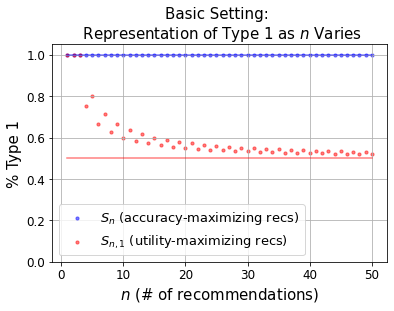

In [7]:
S1 = []
S = []

ns = range(1,51)
for n in ns:
    type_probs = [0.8, 0.2]
    qs = [0.5, 0.5]
    cond_item_probs = generate_cond_item_probs(qs, 0, 0, n)

    S1.append(get_recommendations(type_probs, cond_item_probs, n, consumption_constraint=True)[0]/n)
    S.append(get_recommendations(type_probs, cond_item_probs, n, consumption_constraint=False)[0]/n)

plt.grid()
plt.scatter(ns, S, 10, color="blue", alpha=0.5, label=r'$S_{n}$' + ' (accuracy-maximizing recs)')
plt.scatter(ns, S1, 10, color="red", alpha=0.5, label=r'$S_{n,1}$' + ' (utility-maximizing recs)')
plt.plot([1,50], [1,1], '-', color="blue", alpha=0.5)
plt.plot([1,50], [0.5, 0.5], '-', color="red", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlabel(r'$n$' + ' (# of recommendations)',fontsize=15)
plt.ylabel('% Type 1', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Basic Setting: \n Representation of Type 1 as '+r'$n$' + ' Varies', fontsize=15)
plt.legend(fontsize=13)
plt.savefig('n_varying.png', dpi=300)
plt.show()

## Figure 2

Compute S_n and S_{n,1} as alpha varies for the case (p_1, p_2) = (0.6, 0.4), (q_1, q_2) = (0.7, 0.3), beta=2.
Empirical results are for n=500. Plot proportion of items from type 1.

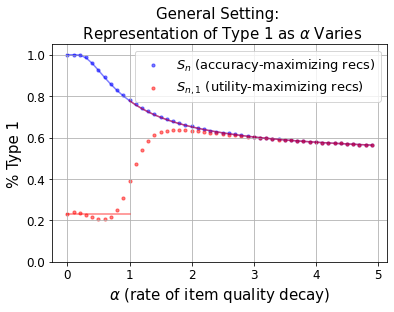

In [6]:
# helper functions for computing our theoretical estimates

def rep_log(qs):
    reps = []
    for q in qs:
        reps.append(1/np.log(1-q))
    return reps/np.sum(reps)

def rep_gamma(xs, gamma):
    reps = []
    for x in xs:
        reps.append(x**gamma)
    return reps/np.sum(reps)

# S_n and S_{n,1} as alpha varies
S = []
S1 = []

# Theoretical estimates for the recommendations S_n
S_theory = []

# Theoretical estimates for the recommendations S_{n,1}
S1_theory_1 = []    # when alpha < 1
S1_theory_2 = []    # when alpha > 1

alphas = np.arange(0, 5, 0.1)
for alpha in alphas:
    n = 500
    beta = 2
    type_probs = [0.6, 0.4]
    qs = [0.7, 0.3]
    cond_item_probs = generate_cond_item_probs(qs, alpha, beta, n)

    S1.append(get_recommendations(type_probs, cond_item_probs, n, consumption_constraint=True)[0]/n)
    S.append(get_recommendations(type_probs, cond_item_probs, n, consumption_constraint=False)[0]/n)
    if alpha < 1:
        S1_theory_1.append(rep_log(qs)[0])
    else:
        S1_theory_2.append(rep_gamma([type_probs[t] * qs[t] for t in range(2)], gamma=1/alpha)[0])
    if alpha == 1:
        S1_theory_1.append(rep_log(qs)[0])
    
    if alpha > 0:
        S_theory.append(rep_gamma([type_probs[t] * qs[t] for t in range(2)], gamma=1/alpha)[0])
    else:
        S_theory.append(1)


# Make plot

plt.grid()
plt.scatter(alphas, S, 10, label=r'$S_{n}$' + ' (accuracy-maximizing recs)', color="blue", alpha=0.5)
plt.scatter(alphas, S1, 10, label=r'$S_{n,1}$' + ' (utility-maximizing recs)', color="red", alpha=0.5)
plt.plot(alphas, S_theory, '-', color="blue", alpha=0.5)
plt.plot(np.arange(0, 1.1, 0.1), S1_theory_1, '-', color="red", alpha=0.5)
plt.plot(np.arange(1, 5, 0.1), S1_theory_2, '-', color="red", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlabel(r'$\alpha$' + ' (rate of item quality decay)',fontsize=15)
plt.ylabel('% Type 1', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('General Setting: \n Representation of Type 1 as '+r'$\alpha$' + ' Varies', fontsize=15)
plt.legend(fontsize=13)
plt.savefig('alpha_varying.png', dpi=300)
plt.show()

## Figure 3

Compute the accuracy and utility of a set of recommendations when the recommendations have varying levels of diversity. Three cases are considered: alpha = 0, alpha = 0.5, and alpha = 1.5. In all settings, (p_1, p_2, p_3) = (0.5, 0.3, 0.2), q_t = 0.2, and beta = 1.

In [13]:
# Given a set of recommendations, type probabilities, and conditional item probabilities, return accuracy and utility (with consumption constraint k)

def evaluate(recommendations, type_probs, cond_item_probs, k=1):
    acc = 0
    for t, nt in enumerate(recommendations):
        acc += type_probs[t] * np.sum(cond_item_probs[t][:nt])
    acc = acc / np.sum(recommendations)
    
    if k==1:
        type_failure_probs = copy.deepcopy(type_probs)
        for t, nt in enumerate(recommendations):
            for i in range(nt):
                type_failure_probs[t] = type_failure_probs[t] * (1 - cond_item_probs[t][i])
        utility = 1 - np.sum(type_failure_probs)

    else:
        utility_estimates = []
        for _ in range(5000):
            utility_estimate = 0
            for t, nt in enumerate(recommendations):
                successes = 0
                for i in range(nt):
                    successes += np.random.binomial(1, cond_item_probs[t][i])
                # if successes >= k:
                #     utility_estimate += type_probs[t]
                utility_estimate += type_probs[t] * min(successes, k)
            utility_estimates.append(utility_estimate)
        utility = np.mean(utility_estimates)
    
    return acc, utility

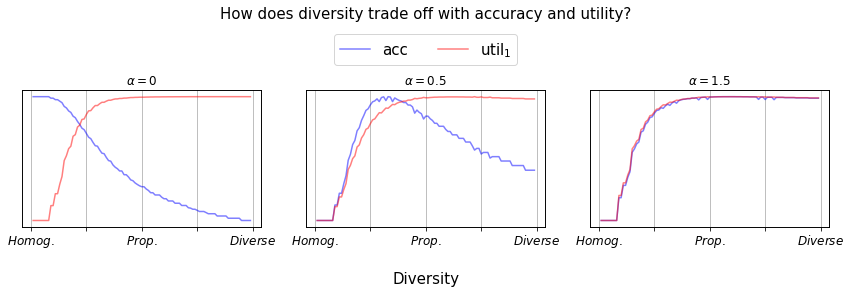

In [12]:
# get recommendations, with gamma controlling the level of diversity
def get_diverse_recommendations(type_probs, n, gamma=0):
    recommendations = [pt ** gamma for pt in type_probs]
    recommendations = recommendations / np.sum(recommendations) * n
    recommendations = recommendations.round().astype(int)
    
    t = 0
    while np.sum(recommendations) < n:
        recommendations[t] = int(recommendations[t] + 1)
        t += 1
    
    return recommendations

n = 100
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
alphas = [0, 0.5, 1.5]
for i, ax in enumerate([ax1, ax2, ax3]):
    type_probs = [0.5, 0.3, 0.2]
    cond_item_probs = generate_cond_item_probs([0.2, 0.2, 0.2], alphas[i], 1, n)

    accs = []
    accs_cc = []
    gammas = np.arange(0.01, 1, 0.01)

    for gamma in gammas:
        recommendations = get_diverse_recommendations([0.5, 0.3, 0.2], n, 1/gamma - 1)
        a, b = evaluate(recommendations, type_probs, cond_item_probs)
        accs.append(a)
        accs_cc.append(b)

    ax.grid(axis='x')
    ax.set_xticks([0,0.25,0.5,0.75,1])
    ax.set_xticklabels([r'$Homog.$', '', r'$Prop.$', '',r'$Diverse$'], fontsize=12)
    color = 'blue'

    if i == 0: # so that only one line is added to legend
        ax.plot(gammas, accs, color=color, alpha=0.5, label='acc')
    else:
        ax.plot(gammas, accs, color=color, alpha=0.5)
    
    ax.set_title(r'$\alpha = $' + str(alphas[i]))
    ax.set_yticks([])

    color = 'red'
    ax_twin = ax.twinx()

    if i == 0:
        ax_twin.plot(gammas, accs_cc, color=color, alpha=0.5, label='util'+r'$_1$')
    else:
        ax_twin.plot(gammas, accs_cc, color=color, alpha=0.5)
    ax_twin.set_yticks([])
    
fig.suptitle('How does diversity trade off with accuracy and utility?' + '\n\n', fontsize = 15)
fig.supxlabel('Diversity', fontsize=15)
fig.tight_layout(pad=1.2)  # otherwise the right y-label is slightly clipped
fig.legend(fontsize=15, loc="lower center", ncol = 2, bbox_to_anchor=(0.5, 0.75))
plt.savefig('tradeoff.png', dpi=300)
plt.show()

# Computational Experiments for Varying Consumption Constraint

In [35]:
# Returns the proportion of items to recommend from each type, given type probabilities, conditional item probabilities, a total number of items n, and a consumption constraint k
def optimal(type_probs, cond_item_probs, n, k):
    current_max = 0
    max_i = 0
    for i in range(0, n+1):
        _, score = evaluate([i, n-i], type_probs, cond_item_probs, k)
        if score > current_max:
            current_max = score
            max_i = i

    return max_i / n

# An example of how to use the function 'optimal' to empirically estimate the composition of optimal recommendations for varying n, k, type probabilities, and conditional item probabilities.
# Here, we print the outputs used to generate Table 4.
for n in [10, 20, 50, 100]:
    opts = []
    print()
    print('n =', n)
    print()
    for alpha in [1, 1.5, 2, 2.5]:
        for k in [1, 2, 5, 10]:
            opt = optimal([0.7, 0.3], generate_cond_item_probs([0.5, 0.5], alpha, 1, n), n, k)  
            opts.append(opt)
    print_statement = ''
    for opt in opts:
        print_statement += str(opt) + ' & '
    print(print_statement)


n = 10

0.7 & 0.7 & 0.7 & 0.7 & 0.7 & 0.7 & 0.7 & 0.6 & 0.6 & 0.6 & 0.6 & 0.5 & 0.6 & 0.5 & 0.6 & 0.6 & 

n = 20

0.65 & 0.7 & 0.75 & 0.65 & 0.65 & 0.75 & 0.65 & 0.6 & 0.6 & 0.65 & 0.45 & 0.4 & 0.6 & 0.5 & 0.75 & 0.6 & 

n = 50

0.64 & 0.66 & 0.76 & 0.72 & 0.64 & 0.62 & 0.68 & 0.74 & 0.6 & 0.68 & 0.64 & 0.6 & 0.58 & 0.6 & 0.32 & 0.42 & 

n = 100

0.64 & 0.57 & 0.75 & 0.72 & 0.64 & 0.63 & 0.64 & 0.72 & 0.61 & 0.58 & 0.46 & 0.62 & 0.59 & 0.39 & 0.44 & 0.54 & 
